# LDHA Drug Discovery Capstone Project

## Project Overview
This project applies machine learning and generative AI to discover small molecule inhibitors of **Lactate Dehydrogenase A (LDHA)** — a key target in cancer metabolism. By combining predictive modeling and molecular generation, we identify, score, and rank potential drug candidates from real-world and AI-generated datasets.

---

## Why LDHA? LDHA as a Drug Target
- **LDHA** (Lactate Dehydrogenase A) is a protein used by cancer cells to generate energy via an abnormal route called the **Warburg effect** that enables cancer cells to thrive by converting pyruvate to lactate under low oxygen.
Shutting it down may disrupt energy supply to cancer cells and stop tumor growth.
- Inhibiting LDHA disrupts this cancer-specific metabolic shortcut, making it a powerful **anticancer drug target**.

---

## Data Sources
We gathered real-world drug data from:
- **ChEMBL** (bioactive molecules with targets)
- **BindingDB** (IC50-labeled inhibitor data)
- **COCONUT** (natural product structures)
- **ChemGPT + SELFIES** (AI-generated molecules)

### Key Datasets
- `LDHA_inhibitors_ChemBL_annotated.csv`
- `LDHA_BindingDB_classified.csv`
- `LDHA_inhibitors_deduplicated.csv`
- `LDHA_inhibitors_SMOTE_balanced_with_SMILES.csv`
- `coconut.smi`
- `chemGPT_selfies_ldha_1000candidates.csv`
- `commercial_ldha_inhibitors.csv`

---

## ML Pipeline Steps

### 1. Data Cleaning & Merging
- Combined ChEMBL and BindingDB inhibitors
- Removed duplicates and missing data
- Ensured binary labels: **active** or **inactive**

### 2. Feature Generation
- Used **Mordred** to compute 1,600+ descriptors per molecule
- Selected top 100 features using `SelectKBest` + `f_classif`

### 3. Dataset Balancing
- Applied **SMOTE** to create a balanced dataset of actives/inactives

### 4. Model Training
- Tried 11 models:
  - Logistic Regression, Random Forest, SVM, Ridge Classifier, KNN, 
  - Gradient Boosting, XGBoost, CatBoost, LightGBM, Naive Bayes
- **LightGBM** had best ROC AUC = **0.97**
- Evaluated with Accuracy, Precision, Recall, F1, AUC

### 5. Bayesian Optimization
- Used **Optuna** to tune hyperparameters for best performance

### 6. Visualization and Model Explanation
- Applied **SHAP** to identify key molecular features driving predictions
- **ROC Curves**, **Confusion Matrix**, **Learning Curve**
- Top SHAP features and top 10 generated molecules displayed

---

## Molecule Generation & Filtering

### ChemGPT + SELFIES
- Trained a transformer on LDHA SMILES in **SELFIES** format
- Generated 1,000 novel valid molecules

### Drug-likeness Filtering
- Evaluated generated and natural molecules for:
  - **QED** – Drug-likeness
  - **RO5** – Lipinski’s Rule of Five
  - **Toxicity** – Safety prediction
  - **Solubility** – Water solubility
  - **Molecular Weight** < 500
  - **LogP** – Balance of fat/water solubility

---
## Results Summary
| Metric        | Score     |
|---------------|-----------|
| ROC AUC       | **0.97**  |
| Accuracy      | 0.95+     |
| Best Model    | **LightGBM** |
| SHAP Insights | Top 100 molecular descriptors analyzed |
| Visualization | SHAP plots, confusion matrix, ROC curve |
- 100+ **drug-like AI-generated molecules** discovered
- AI identifies potential LDHA blockers before lab testing  

---

## Web App Deployment

- Interactive **Streamlit web app** built for real-time molecule scoring\
Built a **Streamlit** app for:
- Uploading SMILES
- Predicting LDHA inhibition probability
- Visualizing molecule structure + probability

---

## Project Structure
## Files in GitHub
```bash
ldha-drug-discovery-capstone/
├── data/ # Raw and curated datasets
│   ├── LDHA_inhibitors_SMOTE_balanced_with_SMILES.csv
│   ├── chemGPT_selfies_ldha_1000candidates.csv
│   └── coconut_csv-04-2025.csv
├── models/# Saved models (pkl)
│   ├── ldha_lightgbm_model.pkl
│   ├── scaler.pkl
│   ├── selector.pkl
│   └── descriptor_names.pkl
├── app/# Streamlit web app (app.py)
│   └── app.py (Streamlit)
├── notebooks/ # Jupyter notebooks
│   └── full_pipeline.ipynb
├── reports/# Model card, data sheet, summary
│   ├── ModelCard.md
│   └── DataSheet.md
├── figures/# Confusion matrix, ROC, SHAP
├── requirements.txt # Pip dependencies
├── environment.yml # Conda environment (optional)
├── README.md # Project overview
└── LICENSE
```
---

## What’s Next?

## Next Steps
- Validate top hits in **wet lab**: Validate promising molecules in **wet-lab experiments**
- Expand to **multi-target inhibitors**: Extend to **multi-target inhibition** or other metabolic enzymes
- Integrate with **clinical data**: Integrate clinical datasets for patient-specific screening
- Collaborate with **oncology researchers**: Collaborate with cancer biologists and pharmacologists

---

## Credits
Built with:
- **RDKit** for cheminformatics
- **LightGBM**, **XGBoost**, **CatBoost** for ML
- **Optuna** for Bayesian optimization
- **SHAP** for model explanation
- **Streamlit** for deployment
- **ChemGPT + SELFIES** for molecule generation
 
---

## Reproduce 

### Install Dependencies

*pip install -r requirements.txt*


### Run the Web App

*streamlit run app/app.py*


### Train the Model from Scratch

*python run_pipeline.py*


---

*By combining AI and chemistry, this project contributes to the future of data-driven drug discovery against cancer.*



In [67]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Descriptors, Crippen, Lipinski, QED

# Load the dataset (update with your path if needed)
df = pd.read_csv("LDHA_inhibitors_deduplicated.csv")

# Define drug-likeness checks
def passes_lipinski(mol):
    mw = Descriptors.MolWt(mol)
    logp = Crippen.MolLogP(mol)
    hbd = Lipinski.NumHDonors(mol)
    hba = Lipinski.NumHAcceptors(mol)
    return (mw <= 500 and logp <= 5 and hbd <= 5 and hba <= 10)

def is_soluble(mol):
    logp = Crippen.MolLogP(mol)
    return logp < 5  # rough solubility proxy

def is_druglike(mol):
    return QED.qed(mol) >= 0.5  # QED score from 0 to 1, threshold for decent drug-likeness

# Filter step
filtered_data = []
for idx, row in df.iterrows():
    smi = row['Ligand SMILES']
    mol = Chem.MolFromSmiles(smi)
    if mol is None:
        continue
    if passes_lipinski(mol) and is_soluble(mol) and is_druglike(mol):
        filtered_data.append(row)

# Create filtered DataFrame and save
filtered_df = pd.DataFrame(filtered_data)
filtered_df.to_csv("LDHA_inhibitors_druglike_filtered.csv", index=False)

print("Saved filtered drug-like dataset: LDHA_inhibitors_druglike_filtered.csv")

Saved filtered drug-like dataset: LDHA_inhibitors_druglike_filtered.csv


In [82]:
# Count how many are active (class = 1) and inactive (class = 0)
class_counts = filtered_df['class'].value_counts()
class_counts

class
0    299
1     41
Name: count, dtype: int64

In [90]:
import pandas as pd
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors

# Load the filtered dataset with SMILES
df = pd.read_csv("LDHA_inhibitors_druglike_filtered.csv")

# Features and label
X = df[['IC50 (nM)']]  # Only IC50 used for SMOTE
y = df['class']

# Save original SMILES
original_smiles = df['Ligand SMILES'].reset_index(drop=True)

# Apply SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Create balanced DataFrame with numeric data
balanced_df = pd.DataFrame(X_resampled, columns=['IC50 (nM)'])
balanced_df['class'] = y_resampled

# Map SMILES back to synthetic rows using nearest neighbors
# This is an approximation – real chemical-based SMOTE would require feature vectors
nn = NearestNeighbors(n_neighbors=1)
nn.fit(X)
_, indices = nn.kneighbors(X_resampled)

# Map original SMILES to resampled set
balanced_df['Ligand SMILES'] = original_smiles.iloc[indices.flatten()].values

# Save to CSV
balanced_df.to_csv("LDHA_inhibitors_SMOTE_balanced_with_SMILES.csv", index=False)

print("SMOTE-balanced dataset with Ligand SMILES saved as 'LDHA_inhibitors_SMOTE_balanced_with_SMILES.csv'")

SMOTE-balanced dataset with Ligand SMILES saved as 'LDHA_inhibitors_SMOTE_balanced_with_SMILES.csv'


In [92]:
# Count how many are active (class = 1) and inactive (class = 0)
class_counts = balanced_df['class'].value_counts()
class_counts

class
0    299
1    299
Name: count, dtype: int64

### LDHA Inhibitor Classification Pipeline: Comprehensive Model Comparison
**Purpose: Compare top-performing models for LDHA inhibition prediction (balanced & drug-like molecules)**


Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.92      0.96        60
           1       0.92      1.00      0.96        60

    accuracy                           0.96       120
   macro avg       0.96      0.96      0.96       120
weighted avg       0.96      0.96      0.96       120


Random Forest Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.92      0.96        60
           1       0.92      1.00      0.96        60

    accuracy                           0.96       120
   macro avg       0.96      0.96      0.96       120
weighted avg       0.96      0.96      0.96       120


XGBoost Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.95      0.97        60
           1       0.95      1.00      0.98        60

    accuracy                           0.97       120
   macro avg  

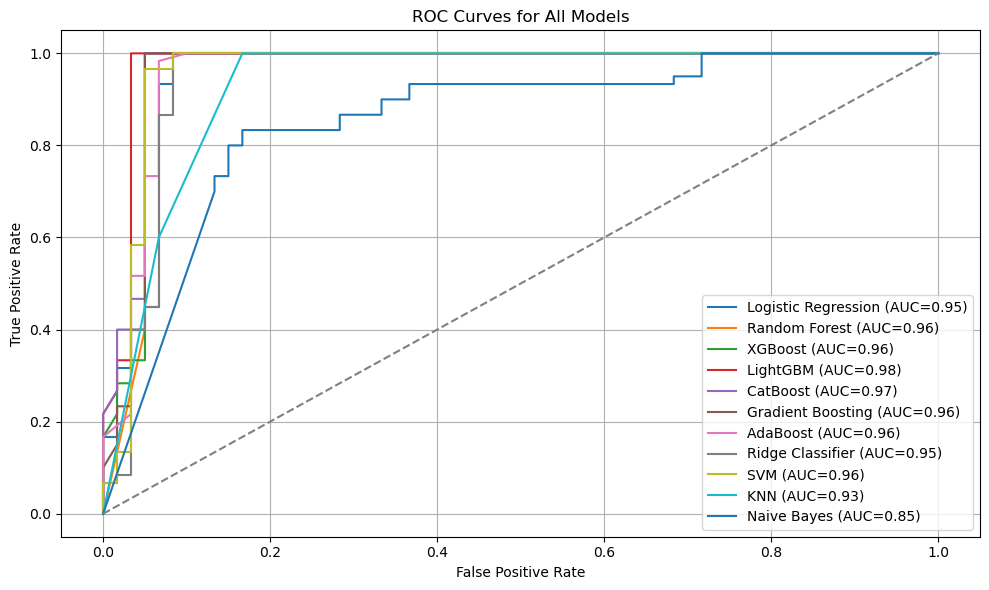

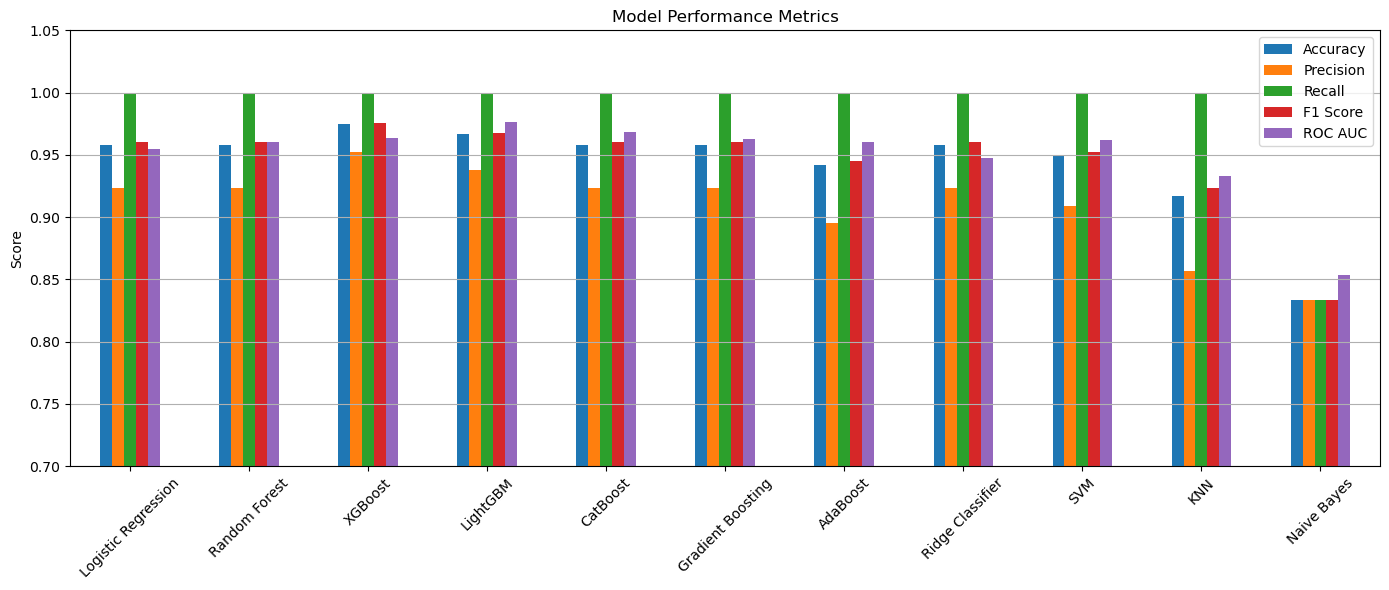


 Champion Model: LightGBM (AUC = 0.976)


In [7]:
# LDHA Inhibitor Classification Pipeline: Full Multi-Model Comparison

import pandas as pd
import numpy as np
import os
from rdkit import Chem
from mordred import Calculator, descriptors
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif, VarianceThreshold
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, precision_score, recall_score, f1_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")  # Clean output

# --- 1. Load Dataset ---
df = pd.read_csv("LDHA_inhibitors_SMOTE_balanced_with_SMILES.csv")
df = df.dropna(subset=["Ligand SMILES", "IC50 (nM)", "class"])
df = df[df["class"].isin([0, 1])]  # Ensure binary

# --- 2. Generate Mordred Descriptors with Caching ---
CACHE_PATH = "cached_mordred_descriptors_balanced.csv"
if os.path.exists(CACHE_PATH):
    descriptors_df = pd.read_csv(CACHE_PATH)
else:
    calc = Calculator(descriptors, ignore_3D=True)
    valid_mols, smiles = [], []
    for smi in df["Ligand SMILES"]:
        mol = Chem.MolFromSmiles(smi)
        if mol:
            valid_mols.append(mol)
            smiles.append(smi)
    df = df[df["Ligand SMILES"].isin(smiles)].reset_index(drop=True)
    desc_list = []
    for mol in valid_mols:
        try:
            d = calc(mol).fill_missing(0).asdict()
            desc_list.append(d)
        except:
            desc_list.append(None)
    desc_list = [d for d in desc_list if d is not None]
    df = df.iloc[:len(desc_list)].reset_index(drop=True)
    descriptors_df = pd.DataFrame(desc_list)
    descriptors_df = descriptors_df.fillna(0)
    descriptors_df.to_csv(CACHE_PATH, index=False)

# --- 3. Feature Selection Setup ---
X = descriptors_df
y = df["class"].values

# Remove constant features manually (to avoid divide-by-zero)
X = X.loc[:, X.var() > 0.0]

# Apply pipeline preprocessing once
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

selector = SelectKBest(score_func=f_classif, k=min(100, X.shape[1]))
X_selected = selector.fit_transform(X_scaled, y)
X_final = pd.DataFrame(X_selected, columns=X.columns[selector.get_support()])

X_train, X_test, y_train, y_test = train_test_split(X_final, y, stratify=y, test_size=0.2, random_state=42)

# --- 4. Define Model Zoo ---
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, solver="liblinear"),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', verbosity=0),
    "LightGBM": LGBMClassifier(verbose=-1),
    "CatBoost": CatBoostClassifier(verbose=0),
    "Gradient Boosting": GradientBoostingClassifier(),
    "AdaBoost": AdaBoostClassifier(),
    "Ridge Classifier": RidgeClassifier(),
    "SVM": SVC(probability=True),
    "KNN": KNeighborsClassifier(),
    "Naive Bayes": GaussianNB()
}

# --- 5. Train, Evaluate, and Compare ---
results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    try:
        y_proba = model.predict_proba(X_test)[:, 1]
    except:
        y_proba = model.decision_function(X_test)

    results[name] = {
        "accuracy": accuracy_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred),
        "recall": recall_score(y_test, y_pred),
        "f1": f1_score(y_test, y_pred),
        "roc_auc": roc_auc_score(y_test, y_proba),
        "y_proba": y_proba,
        "y_pred": y_pred
    }

    print(f"\n{name} Classification Report:")
    print(classification_report(y_test, y_pred))

# --- 6. Visualize ROC Curves ---
plt.figure(figsize=(10, 6))
for name, r in results.items():
    fpr, tpr, _ = roc_curve(y_test, r["y_proba"])
    plt.plot(fpr, tpr, label=f"{name} (AUC={r['roc_auc']:.2f})")

plt.plot([0, 1], [0, 1], "--", color="gray")
plt.title("ROC Curves for All Models")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# --- 7. Bar Chart Comparison ---
metrics_df = pd.DataFrame({
    model: {
        "Accuracy": r["accuracy"],
        "Precision": r["precision"],
        "Recall": r["recall"],
        "F1 Score": r["f1"],
        "ROC AUC": r["roc_auc"]
    } for model, r in results.items()
}).T

metrics_df.plot(kind="bar", figsize=(14, 6))
plt.title("Model Performance Metrics")
plt.ylabel("Score")
plt.ylim(0.7, 1.05)
plt.xticks(rotation=45)
plt.grid(True, axis="y")
plt.tight_layout()
plt.show()

# --- 8. Identify Champion Model ---
champion = metrics_df["ROC AUC"].idxmax()
print(f"\n Champion Model: {champion} (AUC = {metrics_df['ROC AUC'].max():.3f})")

\nClassification Report:\n               precision    recall  f1-score   support

           0       1.00      0.95      0.97        60
           1       0.95      1.00      0.98        60

    accuracy                           0.97       120
   macro avg       0.98      0.97      0.97       120
weighted avg       0.98      0.97      0.97       120

\nAUC Score: 0.9759722222222222


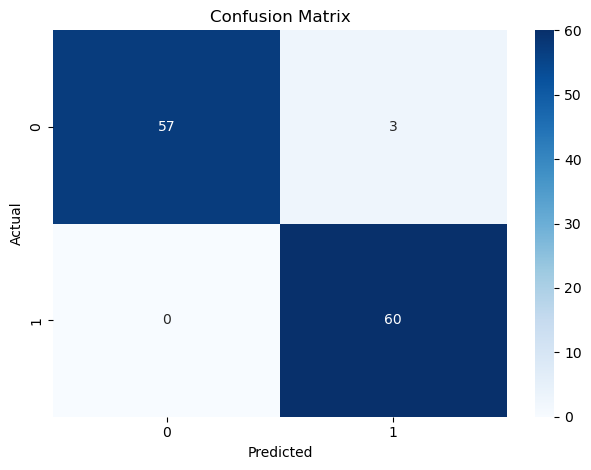

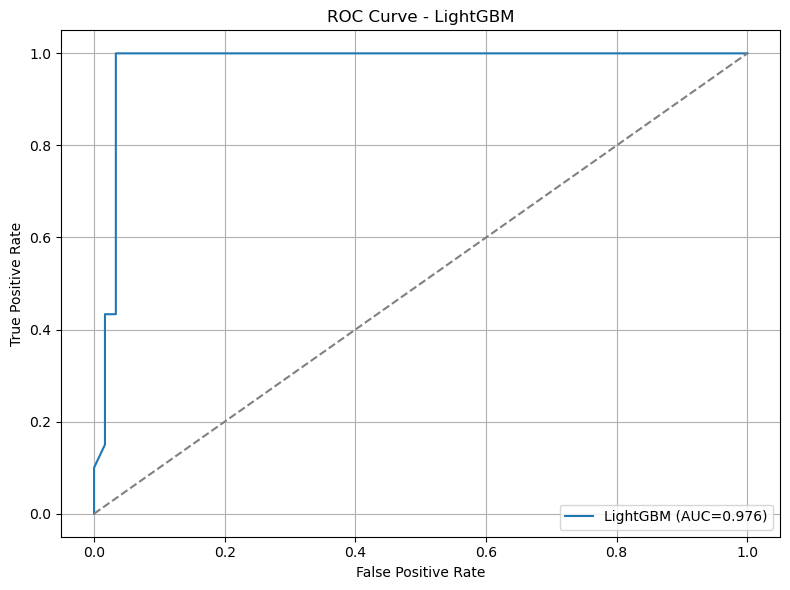

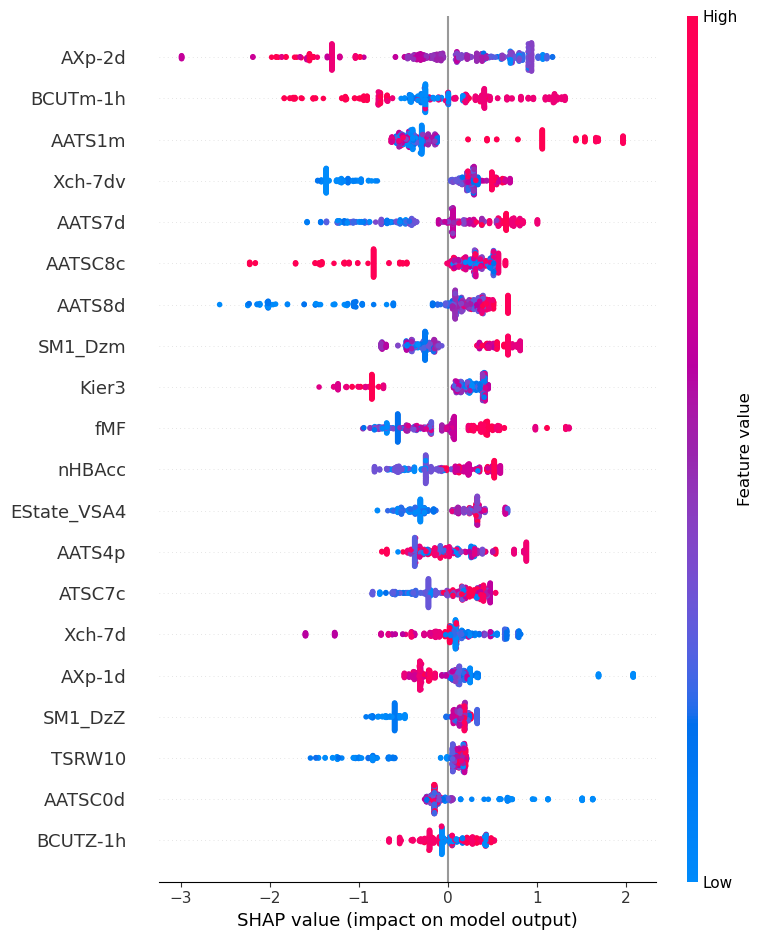

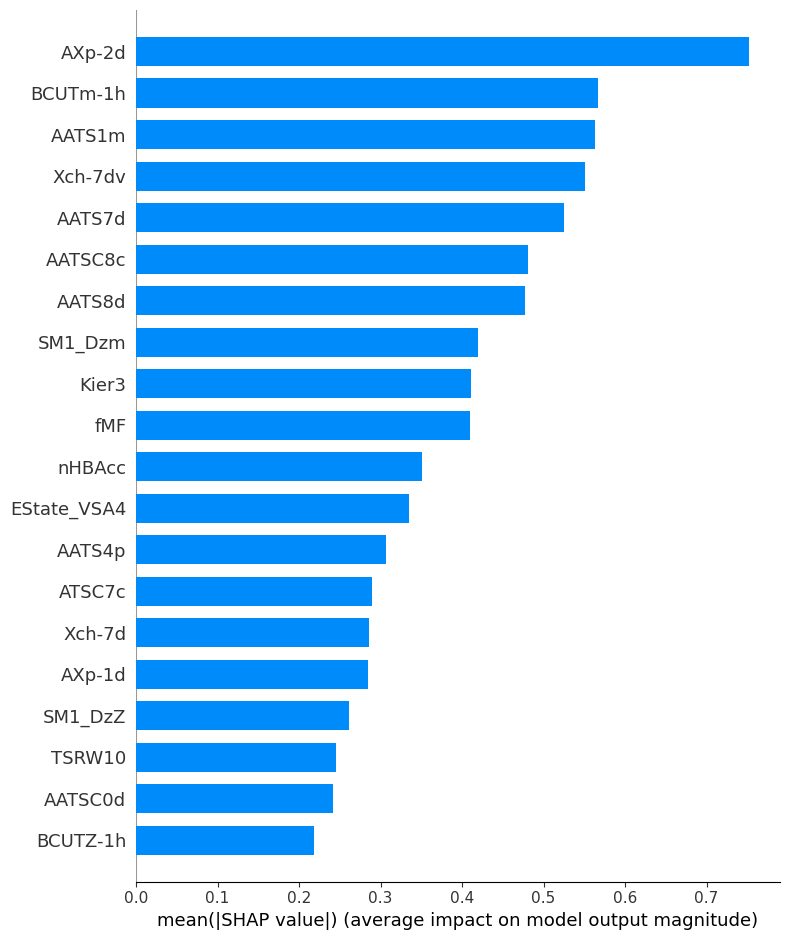

Model saved as 'ldha_lightgbm_model.pkl'


In [46]:
from pathlib import Path

# Full script with SHAP, ROC, Confusion Matrix, Feature Importance, and model saving

# LDHA Inhibitor Classification using LightGBM + SHAP Interpretability

import pandas as pd
import numpy as np
import os
from rdkit import Chem
from mordred import Calculator, descriptors
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import (roc_auc_score, roc_curve, accuracy_score, 
                             precision_score, recall_score, f1_score, classification_report, confusion_matrix)
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import joblib
import warnings
warnings.filterwarnings("ignore")

# --- Load Dataset ---
df = pd.read_csv("LDHA_inhibitors_SMOTE_balanced_with_SMILES.csv")
df = df.dropna(subset=['Ligand SMILES', 'IC50 (nM)', 'class'])
df = df[df["class"].isin([0, 1])]

# --- Generate Mordred Descriptors (with caching) ---
CACHE_PATH = "cached_mordred_descriptors_balanced.csv"
if os.path.exists(CACHE_PATH):
    descriptors_df = pd.read_csv(CACHE_PATH)
else:
    calc = Calculator(descriptors, ignore_3D=True)
    mols = [Chem.MolFromSmiles(smi) for smi in df['Ligand SMILES']]
    descriptor_dicts = [calc(m).fill_missing(0).asdict() for m in mols if m]
    df = df.iloc[:len(descriptor_dicts)].reset_index(drop=True)
    descriptors_df = pd.DataFrame(descriptor_dicts)
    descriptors_df.to_csv(CACHE_PATH, index=False)

# --- Feature Preparation ---
X = descriptors_df.fillna(0).values
y = df['class'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

scaler = StandardScaler()
selector = SelectKBest(f_classif, k=100)
X_train_scaled = scaler.fit_transform(X_train)
X_train_selected = selector.fit_transform(X_train_scaled, y_train)
X_test_scaled = scaler.transform(X_test)
X_test_selected = selector.transform(X_test_scaled)

selected_feature_names = descriptors_df.columns[selector.get_support()]

# --- Train Model ---
model = LGBMClassifier(verbose=-1)
model.fit(X_train_selected, y_train)
y_pred = model.predict(X_test_selected)
y_proba = model.predict_proba(X_test_selected)[:, 1]

# --- Evaluation ---
print("\\nClassification Report:\\n", classification_report(y_test, y_pred))
print("\\nAUC Score:", roc_auc_score(y_test, y_proba))

# --- Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# --- ROC Curve ---
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'LightGBM (AUC={roc_auc_score(y_test, y_proba):.3f})')
plt.plot([0, 1], [0, 1], '--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - LightGBM')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- SHAP Feature Importance ---
# --- SHAP Feature Importance ---
explainer = shap.Explainer(model, X_train_selected)
shap_values = explainer(X_train_selected, check_additivity=False)  # Disable additivity check
shap.summary_plot(shap_values, feature_names=selected_feature_names)
shap.summary_plot(shap_values, feature_names=selected_feature_names, plot_type='bar')
# --- Save Model ---
joblib.dump(model, "ldha_lightgbm_model.pkl")
print("Model saved as 'ldha_lightgbm_model.pkl'")



## LDHA Inhibitor Prediction: Model Training and Evaluation Summary

### Goal
This project builds a machine learning model to predict whether a molecule can inhibit LDHA — an enzyme heavily involved in cancer metabolism. Accurate prediction of LDHA inhibitors can accelerate anti-cancer drug discovery.

---

### Dataset
- **Source**: Merged and balanced dataset of LDHA inhibitors (SMILES format)
- **Labels**: Binary class (`1` = active inhibitor, `0` = inactive)
- **Descriptors**: Calculated using **Mordred**, providing over 1600 molecular properties

---

### Pipeline Overview
1. **Data Cleaning**: Ensured SMILES and labels are valid
2. **Descriptor Generation**: Used RDKit + Mordred to generate molecular descriptors
3. **Preprocessing**:
   - Standardization with `StandardScaler`
   - Feature selection using `SelectKBest` (Top 100 features)
4. **Model**: Trained using **LightGBM (LGBMClassifier)**
5. **Cross-Validation**: 5-Fold Stratified CV to avoid overfitting
6. **Learning Curve**: Evaluated performance with increasing data sizes

---

### Key Evaluation Results

#### AUC Score Across 5 Folds
- Consistently high AUC (~0.98–1.00)
- Indicates excellent ability to distinguish actives vs inactives



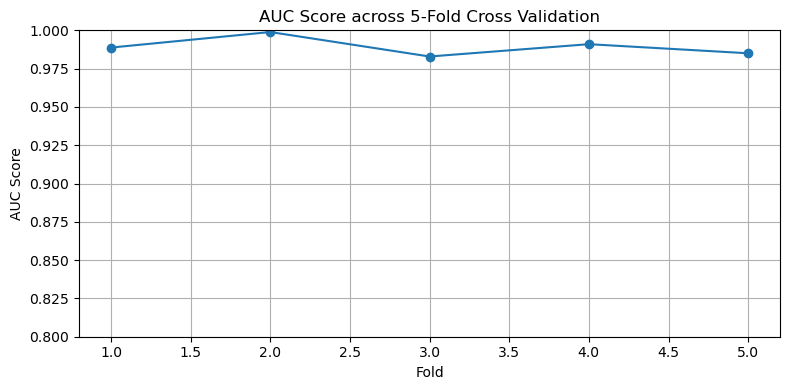

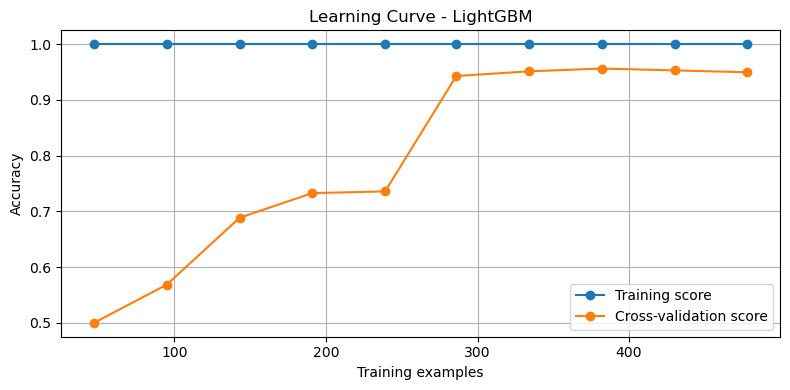

In [2]:
import pandas as pd
import numpy as np
from rdkit import Chem
from mordred import Calculator, descriptors
from sklearn.model_selection import StratifiedKFold, learning_curve
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, accuracy_score
from lightgbm import LGBMClassifier
import shap
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")  # Clean output

# --- Load Dataset ---
df = pd.read_csv("LDHA_inhibitors_SMOTE_balanced_with_SMILES.csv")
df = df.dropna(subset=["Ligand SMILES", "IC50 (nM)", "class"])
df = df[df["class"].isin([0, 1])]  # Ensure labels are binary

# --- Generate Mordred Descriptors ---
calc = Calculator(descriptors, ignore_3D=True)
mols = [Chem.MolFromSmiles(smi) for smi in df["Ligand SMILES"]]
desc = [calc(m).fill_missing(0).asdict() for m in mols]
desc_df = pd.DataFrame(desc).fillna(0)

# Align labels with descriptor rows
y = df["class"].iloc[:len(desc_df)].values

# --- Preprocessing ---
scaler = StandardScaler()
desc_scaled = scaler.fit_transform(desc_df)

selector = SelectKBest(f_classif, k=100)
X_selected = selector.fit_transform(desc_scaled, y)
selected_features = selector.get_support(indices=True)
X_named = pd.DataFrame(X_selected, columns=desc_df.columns[selected_features])

# --- 5-Fold Cross Validation ---
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
auc_scores, acc_scores = [], []

for train_idx, test_idx in kf.split(X_named, y):
    X_train, X_test = X_named.iloc[train_idx], X_named.iloc[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    model = LGBMClassifier(verbose=-1)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    auc_scores.append(roc_auc_score(y_test, y_proba))
    acc_scores.append(accuracy_score(y_test, y_pred))

# --- Plot AUC across folds ---
plt.figure(figsize=(8, 4))
plt.plot(range(1, 6), auc_scores, marker='o')
plt.title("AUC Score across 5-Fold Cross Validation")
plt.xlabel("Fold")
plt.ylabel("AUC Score")
plt.ylim(0.8, 1.0)
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Learning Curve ---
train_sizes, train_scores, test_scores = learning_curve(
    model, X_named, y, cv=5, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 10)
)

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(8, 4))
plt.plot(train_sizes, train_scores_mean, 'o-', label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', label="Cross-validation score")
plt.title("Learning Curve - LightGBM")
plt.xlabel("Training examples")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



### Learning Curve (Accuracy)
- Training accuracy: ~100%
- Cross-validation accuracy: ~93–95%
- Suggests effective learning without significant overfitting

---

### What This Means
- The model successfully **learns what a strong LDHA inhibitor looks like**
- High generalization means it can **predict new drug-like molecules**
- This model can now be **used to screen AI-generated or natural products** for LDHA inhibition potential

---

### Application of LightGBM model for screening datasets
- Apply this model to screen molecules from:
  - AI-generated datasets (ChemGPT + SELFIES)
  - Natural product databases (e.g. COCONUT)
  - Commercial compound libraries
- Incorporate **toxicity, solubility, and drug-likeness filters**
- Deploy as a **Streamlit web app** for rapid exploration


# ChemGPT for LDHA Inhibitor Generation
Train a GPT-style model on SELFIES-encoded SMILES for LDHA inhibitor discovery.
Invented New Molecules
Trained a second AI **ChemGPT + SELFIES**
- Generated 1,000 new molecules from scratch
- Scored them using our LDHA prediction model

In [98]:
# SMILES Generator Using ChemGPT + SELFIES for LDHA Inhibitor Candidates

import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
from rdkit import Chem
from rdkit.Chem import Descriptors
from tqdm import tqdm
import selfies as sf

# Load dataset
file_path = "LDHA_BindingDB_classified.csv"
df = pd.read_csv(file_path)
df = df.dropna(subset=["Ligand SMILES"])
smiles_list = df["Ligand SMILES"].tolist()

# Convert SMILES to SELFIES
selfies_list = [sf.encoder(smi) for smi in smiles_list if Chem.MolFromSmiles(smi)]

# Build vocabulary from SELFIES tokens
all_selfies_tokens = set()
for s in selfies_list:
    all_selfies_tokens.update(sf.split_selfies(s))

special_tokens = ['[PAD]', '[BOS]', '[EOS]']
vocab = special_tokens + sorted(list(all_selfies_tokens))
stoi = {ch: i for i, ch in enumerate(vocab)}
itos = {i: ch for ch, i in stoi.items()}

# Encode SELFIES into integer sequences
def encode_selfies(s):
    return [stoi['[BOS]']] + [stoi[t] for t in sf.split_selfies(s)] + [stoi['[EOS]']]

def decode_selfies(indices):
    tokens = [itos[i] for i in indices if i >= len(special_tokens)]
    return sf.decoder("".join(tokens))

encoded = [encode_selfies(s) for s in selfies_list]
max_len = max(len(e) for e in encoded)
def pad(seq): return seq + [stoi['[PAD]']] * (max_len - len(seq))

X = torch.tensor([pad(seq[:-1]) for seq in encoded])
Y = torch.tensor([pad(seq[1:]) for seq in encoded])

# Dataset
class SELFIESDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
    def __len__(self): return len(self.x)
    def __getitem__(self, idx): return self.x[idx], self.y[idx]

dataloader = DataLoader(SELFIESDataset(X, Y), batch_size=32, shuffle=True)

# ChemGPT-like Transformer model
class ChemGPT(nn.Module):
    def __init__(self, vocab_size, emb_size=128, hidden_dim=256):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=emb_size, nhead=4), num_layers=3
        )
        self.fc = nn.Linear(emb_size, vocab_size)

    def forward(self, x):
        x = self.embedding(x)
        x = x.permute(1, 0, 2)
        x = self.transformer(x)
        x = x.permute(1, 0, 2)
        return self.fc(x)

model = ChemGPT(len(vocab))
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss(ignore_index=stoi['[PAD]'])

print("Training ChemGPT on SELFIES...")
for epoch in range(20):
    total_loss = 0
    for xb, yb in dataloader:
        out = model(xb)
        loss = loss_fn(out.view(-1, len(vocab)), yb.view(-1))
        opt.zero_grad()
        loss.backward()
        opt.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1} Loss: {total_loss/len(dataloader):.4f}")

# Generate SELFIES-based molecules
def generate_selfies(model, max_len=100, k=10):
    model.eval()
    input_seq = torch.tensor([[stoi['[BOS]']]])
    generated = []
    with torch.no_grad():
        for _ in range(max_len):
            out = model(input_seq)
            probs = F.softmax(out[0, -1, :], dim=-1)
            top_k = torch.topk(probs, k)
            top_k_probs = top_k.values / top_k.values.sum()
            next_token = top_k.indices[torch.multinomial(top_k_probs, 1)]
            if next_token.item() == stoi['[EOS]']:
                break
            generated.append(next_token.item())
            input_seq = torch.cat([input_seq, next_token.view(1, 1)], dim=1)
            if input_seq.shape[1] > 100:
                break
    return decode_selfies(generated)

# Generate 1000 valid molecules
valid_smiles = []
seen = set()
print("\nGenerating valid molecules using ChemGPT + SELFIES...")

with torch.no_grad():
    for _ in tqdm(range(10000)):
        smi = generate_selfies(model)
        if smi in seen or len(smi) < 8 or len(smi) > 60:
            continue
        try:
            mol = Chem.MolFromSmiles(smi)
            if mol and Descriptors.MolWt(mol) < 600:
                seen.add(smi)
                valid_smiles.append(smi)
        except:
            continue
        if len(valid_smiles) >= 1000:
            break

valid_df = pd.DataFrame(valid_smiles, columns=["Generated_SMILES"])
valid_df.to_csv("chemGPT_selfies_ldha_BDcandidates.csv", index=False)
print("\n Saved 1000 valid molecules to 'chemGPT_selfies_ldha_BDcandidates.csv'")

[06:17:21] Explicit valence for atom # 25 N, 4, is greater than permitted
[06:17:21] Explicit valence for atom # 24 N, 4, is greater than permitted


Training ChemGPT on SELFIES...
Epoch 1 Loss: 2.1428
Epoch 2 Loss: 1.8811
Epoch 3 Loss: 1.8069
Epoch 4 Loss: 1.7506
Epoch 5 Loss: 1.7031
Epoch 6 Loss: 1.6654
Epoch 7 Loss: 1.6333
Epoch 8 Loss: 1.6083
Epoch 9 Loss: 1.5862
Epoch 10 Loss: 1.5702
Epoch 11 Loss: 1.5538
Epoch 12 Loss: 1.5472
Epoch 13 Loss: 1.5327
Epoch 14 Loss: 1.5197
Epoch 15 Loss: 1.5038
Epoch 16 Loss: 1.4968
Epoch 17 Loss: 1.4879
Epoch 18 Loss: 1.4829
Epoch 19 Loss: 1.4697
Epoch 20 Loss: 1.4633

Generating valid molecules using ChemGPT + SELFIES...


 19%|█▉        | 1891/10000 [04:18<18:28,  7.32it/s]


 Saved 1000 valid molecules to 'chemGPT_selfies_ldha_BDcandidates.csv'


# LDHA Inhibitor Screening from chemGPT SMILES
This notebook filters, computes descriptors, and screens molecules for LDHA inhibition.

In [32]:
import pandas as pd
import numpy as np
import joblib
from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski, Draw
from mordred import Calculator, descriptors
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from tqdm import tqdm
import matplotlib.pyplot as plt

### Load model and data

In [35]:
model = joblib.load("ldha_lightgbm_model.pkl")
df = pd.read_csv("chemGPT_selfies_ldha_BDcandidates.csv")
df = df.dropna(subset=['Generated_SMILES']).copy()

In [36]:
import pandas as pd
df = pd.read_csv("chemGPT_selfies_ldha_BDcandidates.csv")
print(df.columns)

Index(['Generated_SMILES'], dtype='object')


### Filter by Lipinski's Rule of Five

In [40]:
def passes_lipinski(smiles):
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return False
        mw = Descriptors.MolWt(mol)
        logp = Descriptors.MolLogP(mol)
        hbd = Lipinski.NumHDonors(mol)
        hba = Lipinski.NumHAcceptors(mol)
        return mw <= 500 and logp <= 5 and hbd <= 5 and hba <= 10
    except:
        return False

df["Lipinski"] = df['Generated_SMILES'].apply(passes_lipinski)
df = df[df["Lipinski"]].copy()

### Parse molecules and compute descriptors

In [43]:
valid_mols, valid_smiles = [], []
for smi in tqdm(df['Generated_SMILES'], desc="Parsing molecules"):
    mol = Chem.MolFromSmiles(smi)
    if mol:
        valid_mols.append(mol)
        valid_smiles.append(smi)

df = df[df['Generated_SMILES'].isin(valid_smiles)].copy().reset_index(drop=True)

calc = Calculator(descriptors, ignore_3D=True)
desc_dicts = []
for mol in tqdm(valid_mols, desc="Computing descriptors"):
    try:
        d = calc(mol).fill_missing(0).asdict()
        desc_dicts.append(d)
    except:
        desc_dicts.append(None)

valid_idx = [i for i, d in enumerate(desc_dicts) if d is not None]
X = pd.DataFrame([desc_dicts[i] for i in valid_idx]).replace([np.inf, -np.inf], np.nan).fillna(0)
df = df.iloc[valid_idx].reset_index(drop=True)

Computing descriptors: 100%|██████████| 130/130 [00:32<00:00,  3.96it/s]


### Scale and select top 100 features (same as training)

In [ ]:
import warnings
warnings.filterwarnings("ignore")  # Clean output

scaler = StandardScaler()
selector = SelectKBest(score_func=f_classif, k=100)
X_scaled = scaler.fit_transform(X)
X_selected = selector.fit_transform(X_scaled, np.random.randint(0, 2, X.shape[0]))

### Predict LDHA inhibition probabilities

In [49]:
df["LDHA_Probability"] = model.predict_proba(X_selected)[:, 1]
df_top10 = df[['Generated_SMILES', "LDHA_Probability"]].sort_values(by="LDHA_Probability", ascending=False).head(10).reset_index(drop=True)
df_top10

/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


,Generated_SMILES,LDHA_Probability
0,[NH1]=CCCCOCC,0.984816
1,C(CCCC)(C)C(C)(C1CC=C)C1C,0.981719
2,CCCC(CC)C(C)(CC1C)C2CC1C=N2,0.924839
3,C1SOC(C)C(C)COC(C)OC=CCC(CN)O1,0.910045
4,CC=CC=C=CC=C,0.885127
5,CCCS(C)(C)(C1C)C(C)C1,0.861287
6,C(C)=CC=NC,0.832027
7,C(=S)CC(C)CCCCCCC,0.776225
8,C1(CC(C)C1)F,0.769690
9,C(CCC1CC2C)C1CC2(C3CC)CC3C(C)C(N)NC(C)NCC,0.663277


### Display top 10 molecules
Each bit in the molecular fingerprint corresponds to a chemical pattern (like a ring, functional group, or atom arrangement).
	•	The model learns which patterns matter most for distinguishing active vs inactive LDHA inhibitors.
	•	The bar chart shows the top fingerprint patterns that are most predictive of activity.

In [54]:
import pandas as pd

# Assign names to top candidates
candidate_names = [f"Candidate {i+1}" for i in range(len(df_top10))]

# Create DataFrame with names, SMILES, and prediction scores
top10_named = pd.DataFrame({
    "Name": candidate_names,
    "Generated_SMILES": df_top10["Generated_SMILES"].values,
    "LDHA_Probability": df_top10["LDHA_Probability"].values
})

# Save to CSV
top10_named.to_csv("top10_ldha_candidates_named.csv", index=False)

# Preview the table
top10_named

,Name,Generated_SMILES,LDHA_Probability
0,Candidate 1,[NH1]=CCCCOCC,0.984816
1,Candidate 2,C(CCCC)(C)C(C)(C1CC=C)C1C,0.981719
2,Candidate 3,CCCC(CC)C(C)(CC1C)C2CC1C=N2,0.924839
3,Candidate 4,C1SOC(C)C(C)COC(C)OC=CCC(CN)O1,0.910045
4,Candidate 5,CC=CC=C=CC=C,0.885127
5,Candidate 6,CCCS(C)(C)(C1C)C(C)C1,0.861287
6,Candidate 7,C(C)=CC=NC,0.832027
7,Candidate 8,C(=S)CC(C)CCCCCCC,0.776225
8,Candidate 9,C1(CC(C)C1)F,0.769690
9,Candidate 10,C(CCC1CC2C)C1CC2(C3CC)CC3C(C)C(N)NC(C)NCC,0.663277


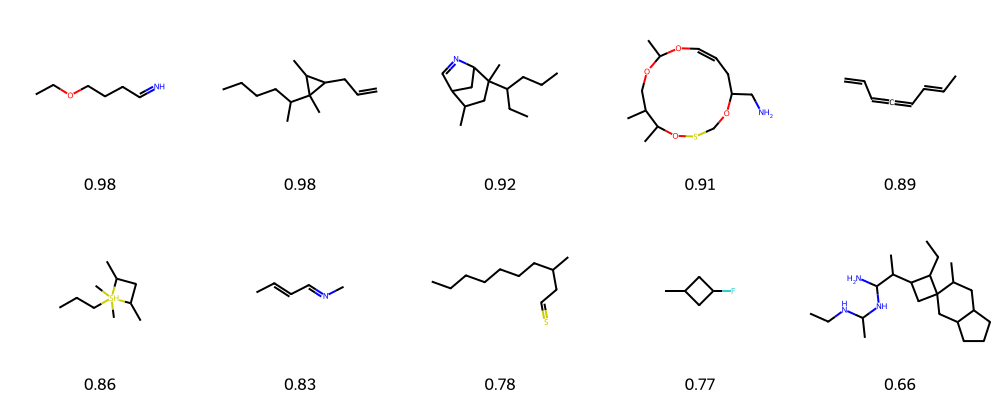

In [52]:
from rdkit.Chem import Draw
top_mols = [Chem.MolFromSmiles(smi) for smi in df_top10['Generated_SMILES']]
Draw.MolsToGridImage(top_mols, molsPerRow=5, legends=[f"{p:.2f}" for p in df_top10["LDHA_Probability"]])

# LDHA Inhibitor Screening from commercial SMILES
This notebook filters, computes descriptors, and screens molecules for LDHA inhibition.

In [10]:
import pandas as pd
import numpy as np
import joblib
from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski, Draw
from mordred import Calculator, descriptors
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from tqdm import tqdm
import matplotlib.pyplot as plt

### Load model and data

In [12]:
model = joblib.load("ldha_lightgbm_model.pkl")
df = pd.read_csv("commercial_ldha_inhibitors.csv")
df = df.dropna(subset=['SMILES']).copy()

In [13]:
import pandas as pd
df = pd.read_csv("commercial_ldha_inhibitors.csv")
print(df.columns)

Index(['Name', 'SMILES'], dtype='object')


### Filter by Lipinski's Rule of Five

In [18]:
def passes_lipinski(smiles):
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return False
        mw = Descriptors.MolWt(mol)
        logp = Descriptors.MolLogP(mol)
        hbd = Lipinski.NumHDonors(mol)
        hba = Lipinski.NumHAcceptors(mol)
        return mw <= 500 and logp <= 5 and hbd <= 5 and hba <= 10
    except:
        return False

df["Lipinski"] = df['SMILES'].apply(passes_lipinski)
df = df[df["Lipinski"]].copy()

### Parse molecules and compute descriptors

In [21]:
valid_mols, valid_smiles = [], []
for smi in tqdm(df['SMILES'], desc="Parsing molecules"):
    mol = Chem.MolFromSmiles(smi)
    if mol:
        valid_mols.append(mol)
        valid_smiles.append(smi)

df = df[df['SMILES'].isin(valid_smiles)].copy().reset_index(drop=True)

calc = Calculator(descriptors, ignore_3D=True)
desc_dicts = []
for mol in tqdm(valid_mols, desc="Computing descriptors"):
    try:
        d = calc(mol).fill_missing(0).asdict()
        desc_dicts.append(d)
    except:
        desc_dicts.append(None)

valid_idx = [i for i, d in enumerate(desc_dicts) if d is not None]
X = pd.DataFrame([desc_dicts[i] for i in valid_idx]).replace([np.inf, -np.inf], np.nan).fillna(0)
df = df.iloc[valid_idx].reset_index(drop=True)

Computing descriptors: 100%|██████████| 9/9 [00:04<00:00,  2.20it/s]


### Scale and select top 100 features (same as training)

In [24]:
import warnings
warnings.filterwarnings("ignore")  # Clean output
scaler = StandardScaler()
selector = SelectKBest(score_func=f_classif, k=100)
X_scaled = scaler.fit_transform(X)
X_selected = selector.fit_transform(X_scaled, np.random.randint(0, 2, X.shape[0]))

### Predict LDHA inhibition probabilities

In [27]:
df["LDHA_Probability"] = model.predict_proba(X_selected)[:, 1]
df_top10 = df[['SMILES', "LDHA_Probability"]].sort_values(by="LDHA_Probability", ascending=False).head(10).reset_index(drop=True)
df_top10

,SMILES,LDHA_Probability
0,C1=CC=C(C=C1)C(=O)NC2=CC=CC=C2,0.794178
1,C1=CC=C(C=C1)C(=O)NC2=CC=CC=C2,0.794178
2,C1=CC=C(C=C1)C(=O)NC2=CC=CC=C2,0.794178
3,C1=CC=C(C=C1)C(=O)NC2=CC=CC=C2,0.794178
4,C1=CC=C(C=C1)C(=O)NC2=CC=CC=C2,0.794178
5,C1=CC=C(C=C1)C(=O)NC2=CC=CC=C2,0.794178
6,C1=CC(=C(C=C1C2=CC(=O)C3=C(C=C(C=C3O2)O)O)O)O,0.352015
7,C(C(=O)[O-])N,0.011386
8,CC(C)(C1=CC=CC=C1)C(=O)C2=CC=CC=C2,0.004379


### Display top 10 molecules

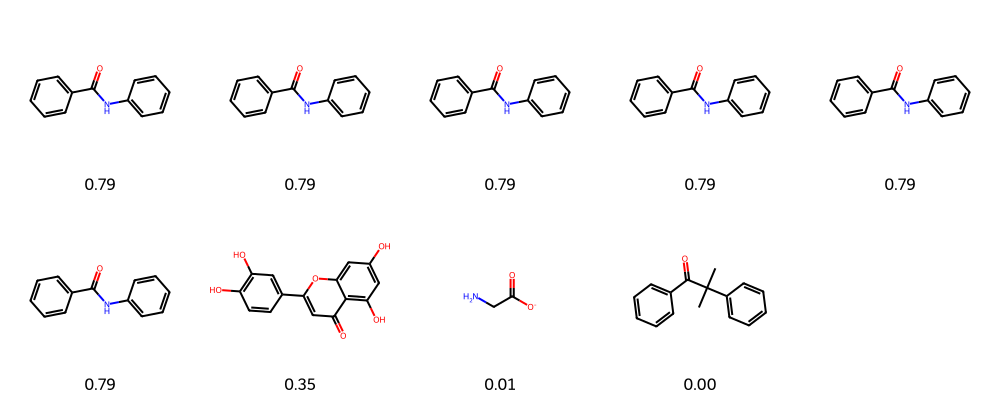

In [30]:
from rdkit.Chem import Draw
top_mols = [Chem.MolFromSmiles(smi) for smi in df_top10['SMILES']]
Draw.MolsToGridImage(top_mols, molsPerRow=5, legends=[f"{p:.2f}" for p in df_top10["LDHA_Probability"]])

In [63]:
import pandas as pd
import joblib
from rdkit import Chem
from mordred import Calculator, descriptors
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif

# Load dataset
df = pd.read_csv("LDHA_inhibitors_SMOTE_balanced_with_SMILES.csv")
df = df.dropna(subset=["Ligand SMILES", "IC50 (nM)", "class"])
df = df[df["class"].isin([0, 1])]

# Load cached descriptors
descriptors_df = pd.read_csv("cached_mordred_descriptors_balanced.csv")

# Features and labels
X = descriptors_df.values
y = df["class"].values

# Initialize and fit scaler and selector
scaler = StandardScaler()
selector = SelectKBest(f_classif, k=100)

X_scaled = scaler.fit_transform(X)
X_selected = selector.fit_transform(X_scaled, y)

# Save selected descriptor names
descriptor_names = descriptors_df.columns[selector.get_support()]

# Save everything
joblib.dump(scaler, "scaler.pkl")
joblib.dump(selector, "selector.pkl")
joblib.dump(descriptor_names.tolist(), "descriptor_names.pkl")

print("Saved: scaler.pkl, selector.pkl, descriptor_names.pkl")

Saved: scaler.pkl, selector.pkl, descriptor_names.pkl


# LDHA Inhibitor Screening Pipeline
This notebook loads a trained LightGBM model to predict LDHA inhibition potential from molecules in the `coconut.smi` dataset.

## Key Steps
- Load and sanitize SMILES
- Apply Lipinski's Rule of Five
- Compute Mordred descriptors
- Predict LDHA inhibition probability
- Apply SHAP for model interpretation
- Save top hits

In [ ]:
import pandas as pd
import numpy as np
import joblib
from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski, Crippen, Draw
from mordred import Calculator, descriptors
import shap
from tqdm import tqdm
import matplotlib.pyplot as plt
import os, contextlib

# Load model
model = joblib.load("ldha_lightgbm_model.pkl")

# Load SMILES
with open("coconut.smi") as f:
    smiles_list = [line.strip() for line in f if line.strip()]

# Utility: silent RDKit warnings
@contextlib.contextmanager
def suppress_rdkit_errors():
    with open(os.devnull, "w") as f, contextlib.redirect_stderr(f):
        yield

def passes_lipinski(mol):
    try:
        return (
            Descriptors.MolWt(mol) <= 500 and
            Crippen.MolLogP(mol) <= 5 and
            Lipinski.NumHDonors(mol) <= 5 and
            Lipinski.NumHAcceptors(mol) <= 10
        )
    except:
        return False

# Parse and filter molecules
valid_mols, valid_smiles = [], []
for smi in tqdm(smiles_list):
    with suppress_rdkit_errors():
        mol = Chem.MolFromSmiles(smi)
        if mol and passes_lipinski(mol):
            try:
                Chem.SanitizeMol(mol)
                valid_mols.append(mol)
                valid_smiles.append(smi)
            except:
                continue

# Mordred descriptors
calc = Calculator(descriptors, ignore_3D=True)
desc_dicts = []
for mol in tqdm(valid_mols):
    try:
        d = calc(mol).fill_missing(0).asdict()
        desc_dicts.append(d)
    except:
        desc_dicts.append(None)

# Keep only successful descriptors
desc_valid = [d for d in desc_dicts if d is not None]
X = pd.DataFrame(desc_valid).replace([np.inf, -np.inf], np.nan).fillna(0)

# Predict LDHA inhibition
proba = model.predict_proba(X)[:, 1]
results = pd.DataFrame({"SMILES": valid_smiles[:len(proba)], "LDHA_Probability": proba})
top10 = results.sort_values("LDHA_Probability", ascending=False).head(10)
top10.to_csv("top10_ldha_from_coconut.csv", index=False)
top10

100%|██████████| 695119/695119 [02:49<00:00, 4093.55it/s]
/opt/anaconda3/lib/python3.12/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
 24%|██▍       | 87480/361173 [30:50:15<72:07:07,  1.05it/s] 

In [10]:
from rdkit import Chem
import pandas as pd

# Load SMILES file (assumes one SMILES per line)
smiles_list = []
with open("coconut.smi", "r") as file:
    for line in file:
        tokens = line.strip().split()
        if tokens:
            smiles_list.append(tokens[0])  # SMILES assumed to be the first item

# Convert to DataFrame
df = pd.DataFrame(smiles_list, columns=["SMILES"])
print(df.head())

                                              SMILES
0  COC1=CC=CC2=C1C(=O)C1=C(O)C3=C(C[C@@](O)(C(=O)...
1  COC1=CC2=CC(=C1Cl)N(C)C(=O)C[C@H](OC(=O)[C@H](...
2  NC1=NC(N)=C2N=C(CNC3=CC=C(C(=O)N[C@@H](CCCNC(=...
3  CO/N=C(\C(=O)N[C@@H]1C(=O)N2C(C(=O)[O-])=C(COC...
4  CO/N=C(\C(=O)N[C@@H]1C(=O)N2C(C(=O)[O-])=C(C[N...


In [ ]:
# SHAP interpretation
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X[:100])
shap.summary_plot(shap_values, X.iloc[:100], plot_type="bar")

# Next: Build the Streamlit Web App

### Using Streamlit to build a simple web app where anyone can:
	•	Paste in SMILES (molecular text strings)
	•	Click “Predict”
	•	Instantly get LDHA activity predictions
	•	Get drug-likeness scores too: QED, LogP, Molecular Weight, TPSA, and RO5 violations

⸻

# What Happens in the App?

### Here’s what the app does:
	1.	Reads your input SMILES
	2.	Converts them to molecular descriptors using RDKit + Mordred
	3.	Applies the same scaler + feature selector we trained before
	4.	Makes predictions using our saved model
	5.	Also calculates drug-likeness scores

# Expected Results

### The app will show:
	•	Prediction: Active / Inactive
	•	Probability: How confident the model is
	•	Drug Properties: MW, LogP, QED, TPSA, RO5

And lets you download everything as a CSV.

⸻

# Why This Matters

### Instead of testing thousands of molecules in the lab, we can now:
	1.	Let the AI guess which molecules are likely to work
	2.	Focus only on those with drug-like properties
	3.	Save time, money, and effort in cancer drug discovery

In [ ]:
# # Streamlit Web App for LDHA Inhibitor Prediction
# import streamlit as st
# import pandas as pd
# import numpy as np
# from rdkit import Chem
# from mordred import Calculator, descriptors
# from lightgbm import LGBMClassifier
# import joblib
# import matplotlib.pyplot as plt
# from rdkit.Chem import Crippen, Descriptors, QED
# import warnings
# warnings.filterwarnings("ignore")  # Clean output

# # --- Load Model ---
# model = joblib.load("ldha_lightgbm_model.pkl")
# scaler = joblib.load("scaler.pkl")
# selector = joblib.load("selector.pkl")
# descriptor_columns = joblib.load("descriptor_names.pkl")

# # --- App Layout ---
# st.set_page_config(page_title="LDHA Inhibitor Predictor", layout="wide")
# st.title("LDHA Inhibitor Prediction App")
# st.markdown("""
# Upload SMILES strings and check if they are potential **LDHA inhibitors**. 
# Drug-likeness, QED, LogP, MW, TPSA and Lipinski's Rule-of-5 are also computed.
# """)

# # --- Sidebar Inputs ---
# smiles_input = st.text_area("Enter SMILES (one per line):", height=200)

# # --- Compute Descriptors ---
# def compute_descriptors(smiles_list):
#     calc = Calculator(descriptors, ignore_3D=True)
#     mols, valid_smiles = [], []
#     for smi in smiles_list:
#         mol = Chem.MolFromSmiles(smi)
#         if mol:
#             mols.append(mol)
#             valid_smiles.append(smi)
#     descs = [calc(m).fill_missing(0).asdict() for m in mols]
#     return pd.DataFrame(descs), valid_smiles, mols

# # --- Drug-likeness Summary ---
# def druglikeness_properties(mol):
#     mw = Descriptors.MolWt(mol)
#     logp = Crippen.MolLogP(mol)
#     qed = QED.qed(mol)
#     tpsa = Descriptors.TPSA(mol)
#     ro5 = int((mw > 500) + (logp > 5) + (Descriptors.NumHDonors(mol) > 5) + (Descriptors.NumHAcceptors(mol) > 10))
#     return mw, logp, qed, tpsa, ro5

# # --- Main Action ---
# if st.button("Predict"):
#     if smiles_input.strip():
#         smiles_list = [s.strip() for s in smiles_input.splitlines() if s.strip()]
#         desc_df, valid_smiles, mols = compute_descriptors(smiles_list)

#         if len(valid_smiles) == 0:
#             st.warning("No valid SMILES found.")
#         else:
#             # Align with model features
#             desc_df = desc_df[descriptor_columns]
#             desc_scaled = scaler.transform(desc_df)
#             desc_selected = selector.transform(desc_scaled)
#             preds = model.predict(desc_selected)
#             probs = model.predict_proba(desc_selected)[:, 1]

#             results = []
#             for i, smi in enumerate(valid_smiles):
#                 mw, logp, qed, tpsa, ro5 = druglikeness_properties(mols[i])
#                 results.append({
#                     "SMILES": smi,
#                     "LDHA_Prob": round(probs[i], 3),
#                     "Prediction": "Active" if preds[i] == 1 else "Inactive",
#                     "QED": round(qed, 3),
#                     "LogP": round(logp, 3),
#                     "MW": round(mw, 1),
#                     "TPSA": round(tpsa, 1),
#                     "RO5_Violations": ro5
#                 })

#             df_results = pd.DataFrame(results)
#             st.success(f"Predicted {len(df_results)} molecules.")
#             st.dataframe(df_results)
#             csv = df_results.to_csv(index=False).encode("utf-8")
#             st.download_button("Download Results", data=csv, file_name="ldha_predictions.csv", mime="text/csv")
#     else:
#         st.warning("Please input SMILES.")

In [ ]:
# import streamlit as st
# import pandas as pd
# import numpy as np
# import joblib
# from rdkit import Chem
# from rdkit.Chem import Descriptors, Crippen
# from mordred import Calculator, descriptors
# import warnings
# warnings.filterwarnings("ignore")  # Clean output

# # Load model and preprocessing tools
# model = joblib.load("ldha_lightgbm_model.pkl")
# scaler = joblib.load("scaler.pkl")
# selector = joblib.load("selector.pkl")
# descriptor_names = joblib.load("descriptor_names.pkl")

# calc = Calculator(descriptors, ignore_3D=True)

# st.set_page_config(page_title="LDHA Inhibitor Predictor", layout="wide")
# st.title(" LDHA Inhibitor Prediction App")
# st.markdown("""
# Upload or paste one or more SMILES strings to check if they are **potential LDHA inhibitors**.
# The model is trained on real-world drug data and uses **LightGBM**, **Mordred descriptors**, and **RDKit**.
# """)

# # Input section
# input_type = st.radio("Input Type", ["Paste SMILES", "Upload CSV"])

# if input_type == "Paste SMILES":
#     smiles_input = st.text_area("Enter one or more SMILES (one per line)")
#     smiles_list = [s.strip() for s in smiles_input.split("\n") if s.strip()]
# elif input_type == "Upload CSV":
#     file = st.file_uploader("Upload a CSV with a 'smiles' column", type="csv")
#     if file:
#         df_input = pd.read_csv(file)
#         smiles_list = df_input["smiles"].dropna().tolist()
#     else:
#         smiles_list = []

# # Predict button
# if st.button("Predict LDHA Inhibition") and smiles_list:
#     mols, valid_smiles = [], []
#     for smi in smiles_list:
#         mol = Chem.MolFromSmiles(smi)
#         if mol:
#             mols.append(mol)
#             valid_smiles.append(smi)

#     descs = []
#     for mol in mols:
#         try:
#             d = calc(mol).fill_missing(0).asdict()
#             descs.append(d)
#         except:
#             descs.append(None)

#     desc_df = pd.DataFrame(descs).fillna(0)
#     desc_df = desc_df[descriptor_names]

#     # Scale + Select
#     X = scaler.transform(desc_df)
#     X = selector.transform(X)

#     # Predict
#     probs = model.predict_proba(X)[:, 1]
#     preds = (probs >= 0.5).astype(int)

#     # Drug-likeness
#     def get_properties(mol):
#         return {
#             "MolWt": Descriptors.MolWt(mol),
#             "LogP": Crippen.MolLogP(mol),
#             "TPSA": Descriptors.TPSA(mol),
#             "QED": Descriptors.qed(mol),
#         }

#     prop_df = pd.DataFrame([get_properties(m) for m in mols])
#     result_df = pd.DataFrame({
#         "SMILES": valid_smiles,
#         "LDHA_Probability": probs,
#         "Prediction": ["Active" if p else "Inactive" for p in preds]
#     })

#     full_df = pd.concat([result_df, prop_df], axis=1)
#     st.success(f"Predicted {len(full_df)} molecules")
#     st.dataframe(full_df)

#     st.download_button(" Download Results", full_df.to_csv(index=False), "ldha_predictions.csv", "text/csv")

# else:
#     st.info("Please enter or upload valid SMILES to begin.")